## Using xr.apply_ufunc to apply a scipy function to every gridpont

Some functions, such as ```scipy.stats.linregress```, cannot vectorise nicely. This notebook provides a few examples of how to apply such functions many times to an xarray dataset, vectorised so that a dask client can speed up the calculation. We answer the dummy question "What is SST trend at each gridpoint of an ocean model, and is it significant?". Scientifically, this question mostly applies to the forcing dataset and not the ocean model, but it's as good an example as any.

To achieve this goal, we use ```xr.apply_ufunc```, which is very versatile, but therefore takes many arguments that can be difficult to interpret at first glance. The aim of the example below is to give something that will work on a problem similar to what COSIMA users may encounter.

Full docs: https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html

Code takes about 5 minutes total on 4 cores

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43549/status,
Dashboard: /proxy/43549/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40271,Workers: 4
Dashboard: /proxy/43549/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37533,Total threads: 1
Dashboard: /proxy/36237/status,Memory: 0 B
Nanny: tcp://127.0.0.1:33455,


In [3]:
# Get some data
session = cc.database.create_session()
experiment = '025deg_jra55_iaf_omip2_cycle6'
sst = cc.querying.getvar(experiment, 'sst', session, frequency='1 monthly')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [4]:
# Rechunk so that there is only one chunk in time dimension, used by the linear regression
sst = sst.chunk({'time':-1}) 

In [5]:
# Make a function that takes the data we have and returns what we want
def get_trend(time,timeseries):
    '''Calculate the trend through a timeseries using scipy.stats.linregress, 
    and return just the slope and p value as an array, for the purposes of 
    demonstrating xr.apply_ufunc
    Inputs:
        time: np.ndarray
            the times or x values of whatever the slope will go through
        timeseries: np.ndarray
            the data to calculate the slope of
    Outputs:
        stats: np.ndarray
            1st element is the trend in timeseries
            2nd element is the p_value of this trend, indicating the significance
            They're lumped together into one variable, a) so .load() can be called 
            on both at once, and b) to demonstrate some of the nuance in xr.apply_ufunc
            when using it for more complicated applications
    '''
        
    slope, intercept, r, p, se = scipy.stats.linregress(time,timeseries)
    return np.array((slope, p)) # Combine into one array because it's easier to load in one go

#Define a timeseries for the linear regression to work (because scipy doesn't like datetimes)
years_since_start = xr.DataArray(np.arange(sst.time.shape[0])/12,
                                 dims=('time',),
                                 coords={'time':sst.time})

#Pass data through to the function
stats = xr.apply_ufunc(get_trend,                            # function being used
                       years_since_start,                    # Argument 1 for function
                       sst,                                  # Argument 2 for function
                       input_core_dims=(('time',),('time',)),# Dimensions the function needs for each argument
                       output_core_dims=(('stat_type',),),   # Dimensions of each output from the function
                       output_sizes={'stat_type': 2},        # The new dimension will have size 2
                       vectorize=True,                       # The function needs to only have one lat and lon at a time
                       dask = 'parallelized',                # Dask is fine, but the function can't handle it so apply_ufuncs needs to
                       )

In [6]:
%time stats.load()
# Put data back into some more useful variable names
sst_trend = stats.sel(stat_type=0)
p_value = stats.sel(stat_type=1)

CPU times: user 24.5 s, sys: 2.85 s, total: 27.3 s
Wall time: 1min 46s


Text(0.5, 1.0, 'ACCESS-OM2-025 SST trend')

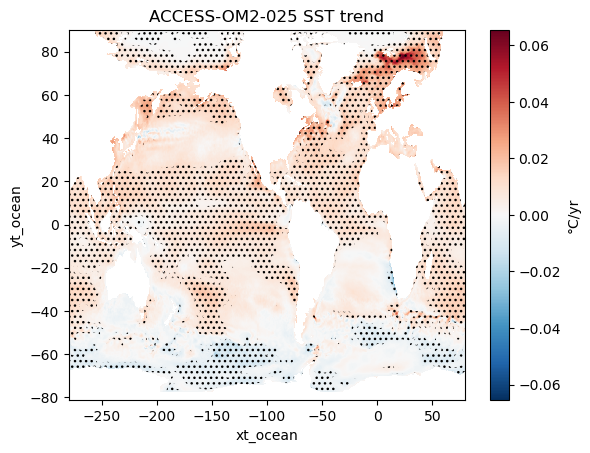

In [8]:
# Plot the calculated slope, stippling all regions that are significant at p<0.05
sst_trend.plot(cbar_kwargs={'label':'°C/yr'})
plt.contourf(p_value.xt_ocean,p_value.yt_ocean,p_value,levels=(0,0.05),colors='None',hatches=('...',))
plt.title('ACCESS-OM2-025 SST trend')